# Time Series Analysis: Sanofi Stock
## Part 1: Data Loading & Initial Forecasting (Before Cleaning)

**Authors:** [Your Group Members]

---

## 1. Setup

In [ ]:
# Install packages (run once)
# !pip install pandas numpy matplotlib seaborn statsmodels prophet scikit-learn yfinance

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

from scipy import stats
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

plt.style.use('seaborn-v0_8-whitegrid')

## 2. Load Data

In [4]:
# Option 1: Download from Yahoo Finance
import yfinance as yf

ticker = "SNY"  # Sanofi
df = yf.download(ticker, start="2019-01-01", end="2024-01-01", progress=False)

# Fix column names if multi-index
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

print(f"Data shape: {df.shape}")
print(f"Date range: {df.index.min().date()} to {df.index.max().date()}")
df.head()

Data shape: (1258, 5)
Date range: 2019-01-02 to 2023-12-29


Price,Close,High,Low,Open,Volume
Date,,,,,
2019-01-02,32.563335,32.631714,32.289821,32.540544,1058500
2019-01-03,32.244232,32.494955,32.221440,32.350601,1722100
2019-01-04,32.532944,32.776067,32.221442,32.312612,1511000
2019-01-07,32.077087,32.251832,31.978318,32.130270,854000
2019-01-08,32.494957,32.517749,32.221443,32.388591,976500


In [2]:
# Option 1: Download from Yahoo Finance
import yfinance as yf

ticker = "AMZN"  # Amazon
df = yf.download(ticker, start="2019-01-01", end="2024-01-01", progress=False)

# Fix column names if multi-index
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

print(f"Data shape: {df.shape}")
print(f"Date range: {df.index.min().date()} to {df.index.max().date()}")
df.head()

Data shape: (1258, 5)
Date range: 2019-01-02 to 2023-12-29


Price,Close,High,Low,Open,Volume
Date,,,,,
2019-01-02,76.956497,77.667999,73.046501,73.260002,159662000
2019-01-03,75.014000,76.900002,74.855499,76.000504,139512000
2019-01-04,78.769501,79.699997,75.915497,76.500000,183652000
2019-01-07,81.475502,81.727997,79.459503,80.115501,159864000
2019-01-08,82.829002,83.830498,80.830498,83.234497,177628000


In [52]:
# Option 1: Download from Yahoo Finance
import yfinance as yf

ticker = "TSLA"  # tesla
df = yf.download(ticker, start="2019-01-01", end="2024-01-01", progress=False)

# Fix column names if multi-index
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

print(f"Data shape: {df.shape}")
print(f"Date range: {df.index.min().date()} to {df.index.max().date()}")
df.head()

Data shape: (1258, 5)
Date range: 2019-01-02 to 2023-12-29


Price,Close,High,Low,Open,Volume
Date,,,,,
2019-01-02,20.674667,21.008667,19.920000,20.406668,174879000
2019-01-03,20.024000,20.626667,19.825333,20.466667,104478000
2019-01-04,21.179333,21.200001,20.181999,20.400000,110911500
2019-01-07,22.330667,22.449333,21.183332,21.448000,113268000
2019-01-08,22.356667,22.934000,21.801332,22.797333,105127500


In [3]:
# Option 1: Download from Yahoo Finance
import yfinance as yf

ticker = "WMT"  # Walmart
df = yf.download(ticker, start="2019-01-01", end="2024-01-01", progress=False)

# Fix column names if multi-index
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

print(f"Data shape: {df.shape}")
print(f"Date range: {df.index.min().date()} to {df.index.max().date()}")
df.head()

Data shape: (1258, 5)
Date range: 2019-01-02 to 2023-12-29


Price,Close,High,Low,Open,Volume
Date,,,,,
2019-01-02,28.024437,28.117512,27.514029,27.514029,24458100
2019-01-03,27.880327,28.435772,27.832289,27.985411,24831900
2019-01-04,28.054474,28.120525,27.829293,27.985418,24087300
2019-01-07,28.384733,28.573886,27.976407,28.108513,23369100
2019-01-08,28.582893,28.751028,28.195583,28.540859,21602700


In [4]:
# Quick look at the data
print("Data Info:")
print(df.info())
print("\nStatistics:")
df.describe()

Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2019-01-02 to 2023-12-29
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1258 non-null   float64
 1   High    1258 non-null   float64
 2   Low     1258 non-null   float64
 3   Open    1258 non-null   float64
 4   Volume  1258 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 59.0 KB
None

Statistics:


Price,Close,High,Low,Open,Volume
count,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03
mean,42.189055,42.534774,41.844105,42.176650,2.263501e+07
std,6.285495,6.312283,6.271562,6.300150,1.254503e+07
min,27.880327,28.117512,27.514029,27.514029,6.682200e+06
25%,36.783239,37.123758,36.495519,36.747262,1.534508e+07
50%,43.679131,44.042693,43.420146,43.692637,1.933185e+07
75%,46.347122,46.715308,45.954514,46.394375,2.537632e+07
max,55.187836,55.239844,54.449959,54.732758,1.329402e+08


In [ ]:
# Our target: Close price
ts = df['Close'].copy()
print(f"Close price - Mean: ${ts.mean():.2f}, Min: ${ts.min():.2f}, Max: ${ts.max():.2f}")

Close price - Mean: $42.19, Min: $27.88, Max: $55.19


## 3. Quick Visualization

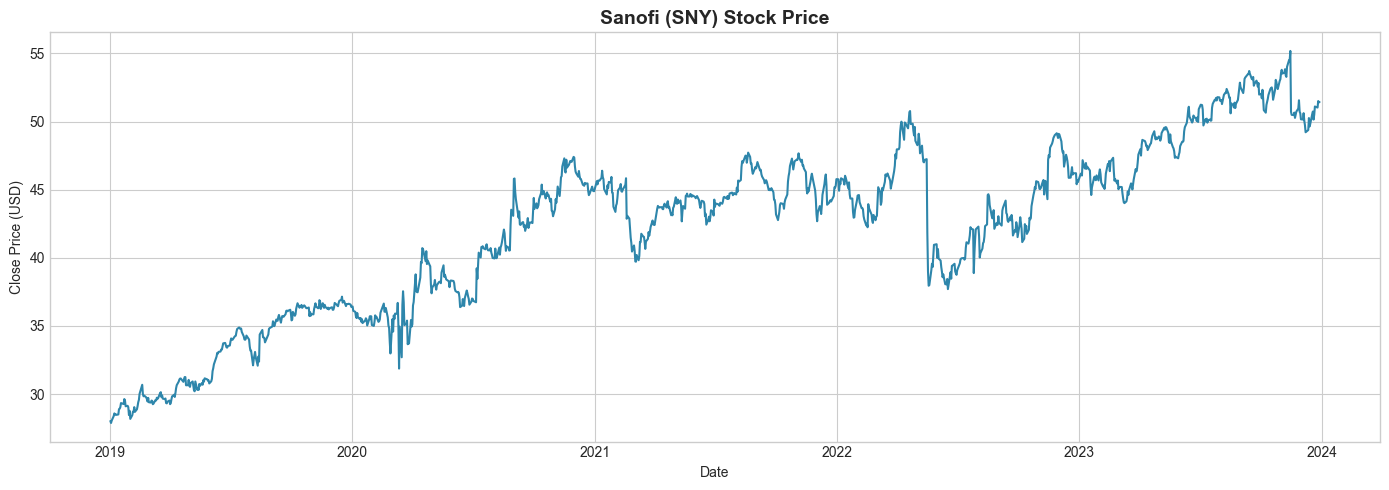

In [6]:
plt.figure(figsize=(14, 5))
plt.plot(ts.index, ts.values, color='#2E86AB')
plt.title('Sanofi (SNY) Stock Price', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.tight_layout()
plt.show()

## 4. Train-Test Split

In [7]:
# 80-20 split
train_size = int(len(ts) * 0.8)
train = ts[:train_size]
test = ts[train_size:]

print(f"Training: {len(train)} days ({train.index.min().date()} to {train.index.max().date()})")
print(f"Testing: {len(test)} days ({test.index.min().date()} to {test.index.max().date()})")

Training: 1006 days (2019-01-02 to 2022-12-28)
Testing: 252 days (2022-12-29 to 2023-12-29)


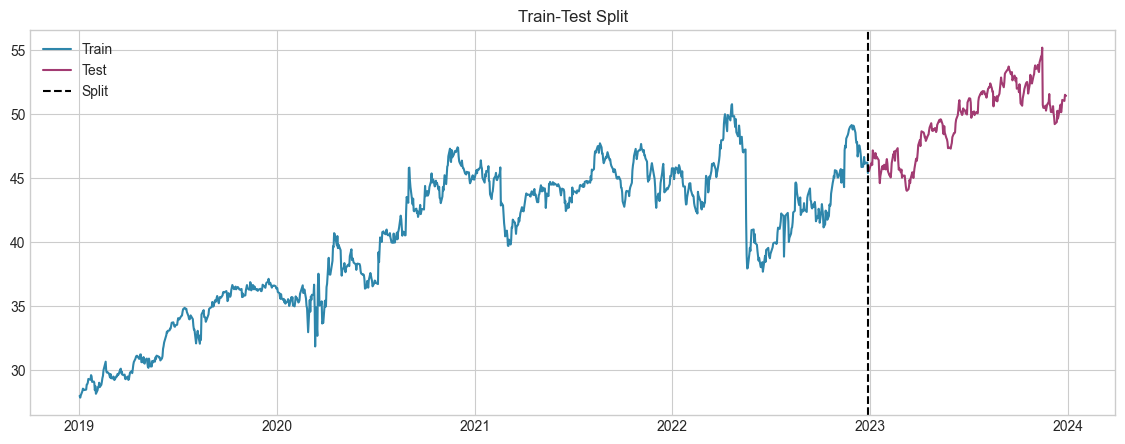

In [8]:
# Visualize split
plt.figure(figsize=(14, 5))
plt.plot(train.index, train.values, label='Train', color='#2E86AB')
plt.plot(test.index, test.values, label='Test', color='#A23B72')
plt.axvline(x=train.index[-1], color='black', linestyle='--', label='Split')
plt.title('Train-Test Split')
plt.legend()
plt.show()

## 5. Evaluation Function

In [9]:
def evaluate_forecast(actual, predicted, model_name):
    """Calculate forecast metrics"""
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    
    print(f"\n{model_name}:")
    print(f"  MAE:  ${mae:.4f}")
    print(f"  RMSE: ${rmse:.4f}")
    print(f"  MAPE: {mape:.2f}%")
    
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

---
# INITIAL FORECASTING (Before any cleaning/analysis)
---

## 6. ARIMA Forecast (Initial)

In [10]:
# Fit ARIMA(2,1,2) - a reasonable starting point
print("Fitting ARIMA(2,1,2)...")
arima_model = ARIMA(train, order=(2, 1, 2))
arima_fit = arima_model.fit()

print(f"AIC: {arima_fit.aic:.2f}")
print(f"BIC: {arima_fit.bic:.2f}")

Fitting ARIMA(2,1,2)...


c:\Users\Ritik\anaconda3\envs\ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Ritik\anaconda3\envs\ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Ritik\anaconda3\envs\ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


AIC: 1781.65
BIC: 1806.21


c:\Users\Ritik\anaconda3\envs\ml\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [11]:
# Forecast
arima_forecast = arima_fit.forecast(steps=len(test))
arima_forecast.index = test.index

# Evaluate
arima_metrics_initial = evaluate_forecast(test.values, arima_forecast.values, 'ARIMA (Initial)')


ARIMA (Initial):
  MAE:  $4.2306
  RMSE: $4.9359
  MAPE: 8.29%


c:\Users\Ritik\anaconda3\envs\ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


## 7. SARIMA Forecast (Initial)

In [12]:
# Fit SARIMA with weekly seasonality (5 trading days)
print("Fitting SARIMA(2,1,2)(1,0,1,5)...")
try:
    sarima_model = SARIMAX(train, order=(2,1,2), seasonal_order=(1,0,1,5))
    sarima_fit = sarima_model.fit(disp=False)
    
    sarima_forecast = sarima_fit.forecast(steps=len(test))
    sarima_forecast.index = test.index
    
    sarima_metrics_initial = evaluate_forecast(test.values, sarima_forecast.values, 'SARIMA (Initial)')
    print(f"AIC: {sarima_fit.aic:.2f}, BIC: {sarima_fit.bic:.2f}")
except Exception as e:
    print(f"SARIMA failed: {e}")
    sarima_forecast = arima_forecast.copy()
    sarima_metrics_initial = arima_metrics_initial.copy()

c:\Users\Ritik\anaconda3\envs\ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Ritik\anaconda3\envs\ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Fitting SARIMA(2,1,2)(1,0,1,5)...

SARIMA (Initial):
  MAE:  $4.2777
  RMSE: $4.9834
  MAPE: 8.38%
AIC: 1788.16, BIC: 1822.55


c:\Users\Ritik\anaconda3\envs\ml\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Ritik\anaconda3\envs\ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


## 8. Prophet Forecast (Initial)

In [13]:
# ============================================
# FIXED Prophet Forecast (Initial) - Replace Section 8
# ============================================

# Prepare data for Prophet
prophet_train = pd.DataFrame({'ds': train.index, 'y': train.values})

print("Fitting Prophet...")
prophet_model = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True)
prophet_model.fit(prophet_train)

# Create future dataframe using ACTUAL test dates (not generated dates)
future = pd.DataFrame({'ds': ts.index})  # Use all actual dates from your data
prophet_forecast_full = prophet_model.predict(future)

# Get test predictions by matching actual test dates
prophet_test_df = prophet_forecast_full[prophet_forecast_full['ds'].isin(test.index)]
prophet_pred = prophet_test_df['yhat'].values

# Verify lengths match
print(f"Test length: {len(test)}, Prophet predictions: {len(prophet_pred)}")

# Evaluate
prophet_metrics_initial = evaluate_forecast(test.values, prophet_pred, 'Prophet (Initial)')

Fitting Prophet...


23:53:51 - cmdstanpy - INFO - Chain [1] start processing
23:53:52 - cmdstanpy - INFO - Chain [1] done processing


Test length: 252, Prophet predictions: 252

Prophet (Initial):
  MAE:  $7.1363
  RMSE: $7.7081
  MAPE: 14.15%


## 9. Compare Initial Forecasts

In [14]:
# Summary table
initial_results = pd.DataFrame({
    'Model': ['ARIMA', 'SARIMA', 'Prophet'],
    'MAE': [arima_metrics_initial['MAE'], sarima_metrics_initial['MAE'], prophet_metrics_initial['MAE']],
    'RMSE': [arima_metrics_initial['RMSE'], sarima_metrics_initial['RMSE'], prophet_metrics_initial['RMSE']],
    'MAPE (%)': [arima_metrics_initial['MAPE'], sarima_metrics_initial['MAPE'], prophet_metrics_initial['MAPE']]
})

print("\n" + "="*50)
print("INITIAL FORECASTING RESULTS (Before Cleaning)")
print("="*50)
display(initial_results.round(4))


INITIAL FORECASTING RESULTS (Before Cleaning)


,Model,MAE,RMSE,MAPE (%)
0,ARIMA,4.2306,4.9359,8.2853
1,SARIMA,4.2777,4.9834,8.3788
2,Prophet,7.1363,7.7081,14.1503


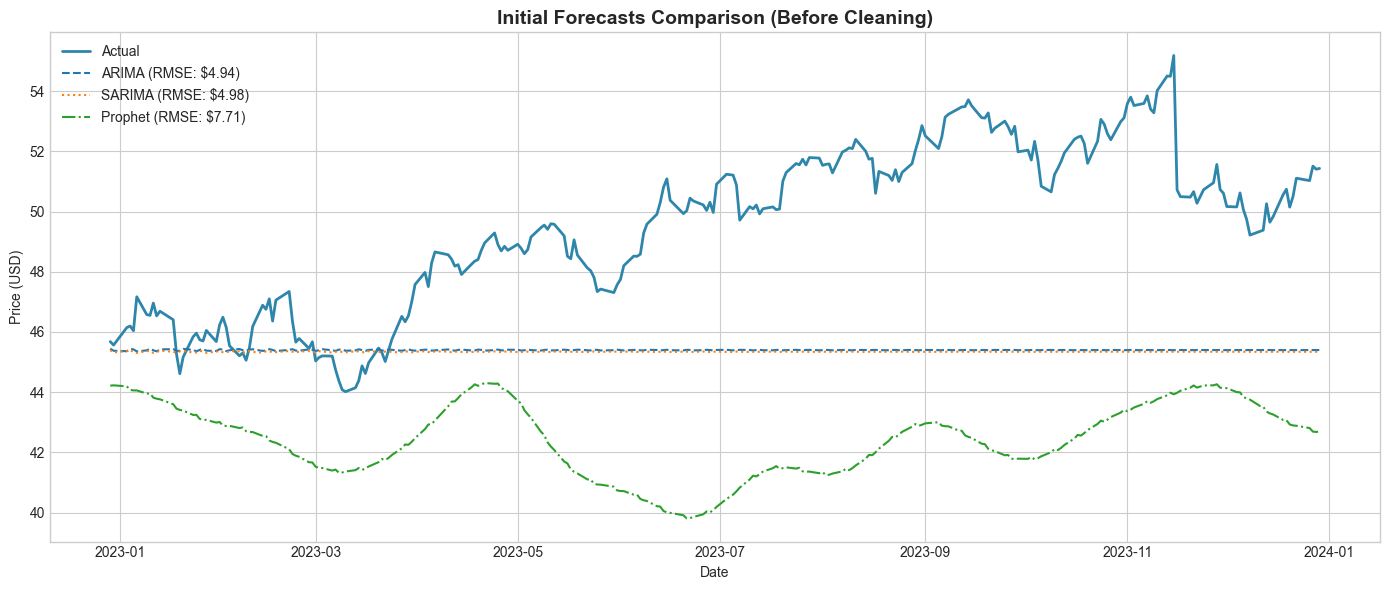

In [15]:
# Visualize all forecasts
plt.figure(figsize=(14, 6))
plt.plot(test.index, test.values, label='Actual', color='#2E86AB', linewidth=2)
plt.plot(test.index, arima_forecast.values, label=f'ARIMA (RMSE: ${arima_metrics_initial["RMSE"]:.2f})', linestyle='--')
plt.plot(test.index, sarima_forecast.values, label=f'SARIMA (RMSE: ${sarima_metrics_initial["RMSE"]:.2f})', linestyle=':')
plt.plot(test.index, prophet_pred, label=f'Prophet (RMSE: ${prophet_metrics_initial["RMSE"]:.2f})', linestyle='-.')

plt.title('Initial Forecasts Comparison (Before Cleaning)', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.tight_layout()
plt.savefig('initial_forecast_comparison.png', dpi=150)
plt.show()

In [16]:
# Save results for later comparison
initial_results.to_csv('initial_forecast_results.csv', index=False)
print("\nResults saved! Continue with Part 2 for analysis and re-forecasting.")


Results saved! Continue with Part 2 for analysis and re-forecasting.


---
## Next Steps (Part 2):
1. Stationarity Testing (ADF test)
2. ACF/PACF Analysis
3. Decomposition (for understanding, not forecasting)
4. Anomaly Detection
5. Re-Forecasting after cleaning
6. Compare Before vs After
---

---
# STEP 1: STATIONARITY TESTING
---

## What is Stationarity?

A **stationary** time series has:
- Constant mean over time
- Constant variance over time
- No trend or seasonality

**Why it matters:** ARIMA requires stationary data to work properly!

## 3. ADF Test (Augmented Dickey-Fuller)

In [17]:
pip install adfuller

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement adfuller (from versions: none)
ERROR: No matching distribution found for adfuller


In [18]:
def adf_test(series, title=''):
    """
    Augmented Dickey-Fuller Test
    
    H0 (Null): Series is NON-stationary (has unit root)
    H1 (Alt): Series IS stationary
    
    If p-value < 0.05: Reject H0 → Series is STATIONARY
    If p-value >= 0.05: Fail to reject H0 → Series is NON-STATIONARY
    """
    print(f"\n{'='*50}")
    print(f"ADF Test: {title}")
    print(f"{'='*50}")
    
    result = adfuller(series.dropna(), autolag='AIC')
    
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print(f"Lags Used: {result[2]}")
    print(f"\nCritical Values:")
    for key, value in result[4].items():
        print(f"   {key}: {value:.4f}")
    
    if result[1] < 0.05:
        print(f"\n✅ RESULT: Series is STATIONARY (p-value < 0.05)")
        return True
    else:
        print(f"\n❌ RESULT: Series is NON-STATIONARY (p-value >= 0.05)")
        return False

In [19]:
# Test ORIGINAL series
print("\n" + "#"*50)
print("TESTING ORIGINAL SERIES")
print("#"*50)

is_stationary_original = adf_test(ts, 'Original Close Price')


##################################################
TESTING ORIGINAL SERIES
##################################################

ADF Test: Original Close Price
ADF Statistic: -1.8881
p-value: 0.3377
Lags Used: 9

Critical Values:
   1%: -3.4356
   5%: -2.8639
   10%: -2.5680

❌ RESULT: Series is NON-STATIONARY (p-value >= 0.05)


In [20]:
# Apply FIRST DIFFERENCING to make it stationary
# Differencing: today's value - yesterday's value
ts_diff = ts.diff().dropna()

print("\n" + "#"*50)
print("TESTING FIRST DIFFERENCE (d=1)")
print("#"*50)

is_stationary_diff = adf_test(ts_diff, 'First Difference')


##################################################
TESTING FIRST DIFFERENCE (d=1)
##################################################

ADF Test: First Difference
ADF Statistic: -12.0517
p-value: 0.0000
Lags Used: 8

Critical Values:
   1%: -3.4356
   5%: -2.8639
   10%: -2.5680

✅ RESULT: Series is STATIONARY (p-value < 0.05)


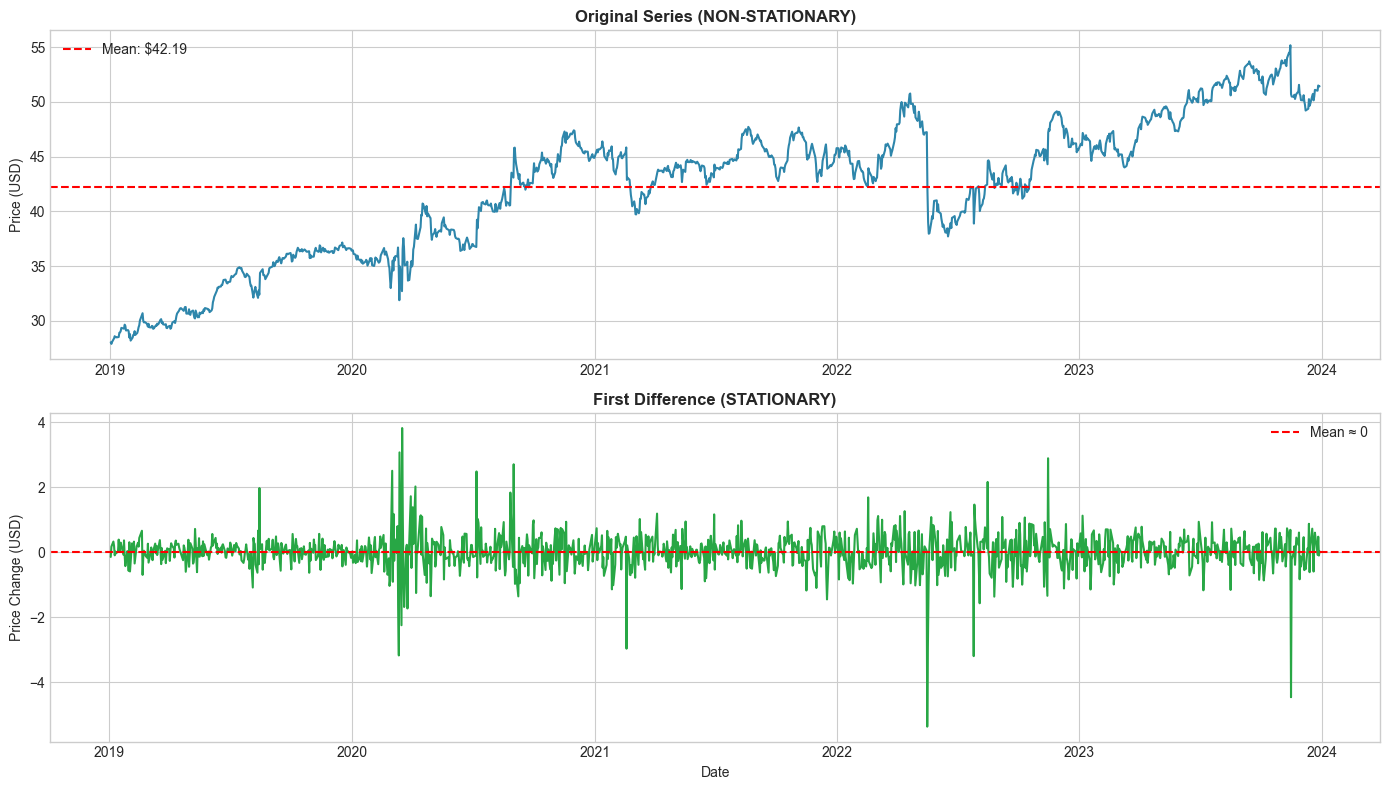


📌 CONCLUSION: We need d=1 (first differencing) for ARIMA


In [21]:
# Visualize: Original vs Differenced
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Original
axes[0].plot(ts.index, ts.values, color='#2E86AB')
axes[0].set_title('Original Series (NON-STATIONARY)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Price (USD)')
axes[0].axhline(y=ts.mean(), color='red', linestyle='--', label=f'Mean: ${ts.mean():.2f}')
axes[0].legend()

# Differenced
axes[1].plot(ts_diff.index, ts_diff.values, color='#28A745')
axes[1].set_title('First Difference (STATIONARY)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Price Change (USD)')
axes[1].axhline(y=0, color='red', linestyle='--', label='Mean ≈ 0')
axes[1].legend()
axes[1].set_xlabel('Date')

plt.tight_layout()
plt.savefig('stationarity_comparison.png', dpi=150)
plt.show()

print("\n📌 CONCLUSION: We need d=1 (first differencing) for ARIMA")

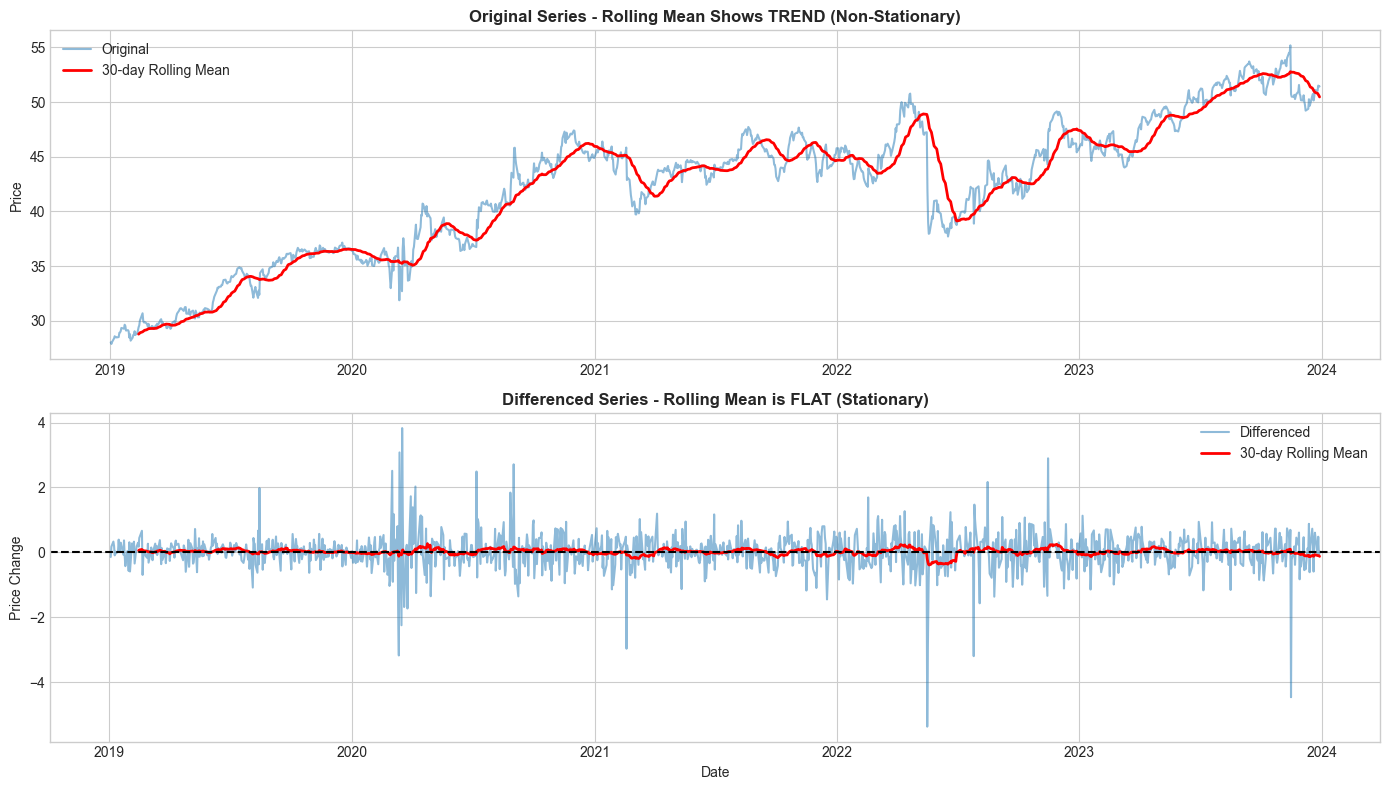

In [22]:
# Rolling Statistics Visualization
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Original - Rolling Mean & Std
rolling_mean = ts.rolling(window=30).mean()
rolling_std = ts.rolling(window=30).std()

axes[0].plot(ts.index, ts.values, label='Original', alpha=0.5)
axes[0].plot(rolling_mean.index, rolling_mean.values, label='30-day Rolling Mean', color='red', linewidth=2)
axes[0].set_title('Original Series - Rolling Mean Shows TREND (Non-Stationary)', fontweight='bold')
axes[0].legend()
axes[0].set_ylabel('Price')

# Differenced - Rolling Mean & Std
rolling_mean_diff = ts_diff.rolling(window=30).mean()
rolling_std_diff = ts_diff.rolling(window=30).std()

axes[1].plot(ts_diff.index, ts_diff.values, label='Differenced', alpha=0.5)
axes[1].plot(rolling_mean_diff.index, rolling_mean_diff.values, label='30-day Rolling Mean', color='red', linewidth=2)
axes[1].axhline(y=0, color='black', linestyle='--')
axes[1].set_title('Differenced Series - Rolling Mean is FLAT (Stationary)', fontweight='bold')
axes[1].legend()
axes[1].set_ylabel('Price Change')
axes[1].set_xlabel('Date')

plt.tight_layout()
plt.savefig('rolling_statistics.png', dpi=150)
plt.show()

---
# STEP 2: ACF and PACF ANALYSIS
---

## What are ACF and PACF?

- **ACF (Autocorrelation Function)**: Correlation between the series and its lagged values
- **PACF (Partial Autocorrelation Function)**: Direct correlation at each lag (removing intermediate effects)

## Why we need them:
They help us choose **p** and **q** for ARIMA(p,d,q)

| Pattern | ACF | PACF | Model |
|---------|-----|------|-------|
| AR(p) | Tails off gradually | Cuts off after lag p | Use PACF to find p |
| MA(q) | Cuts off after lag q | Tails off gradually | Use ACF to find q |
| ARMA(p,q) | Tails off | Tails off | Need both |

## 4. ACF/PACF Plots

In [23]:
pip install plot_acf

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement plot_acf (from versions: none)
ERROR: No matching distribution found for plot_acf


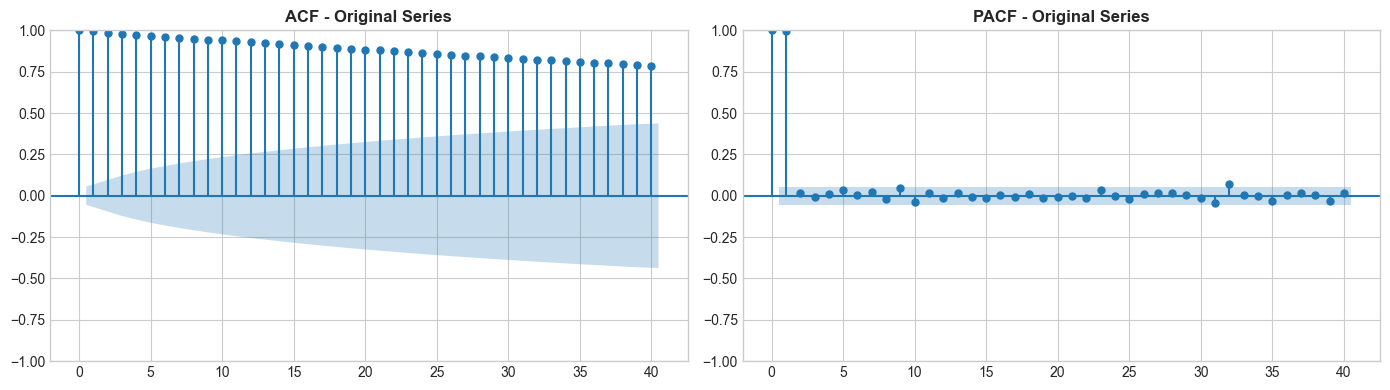

📌 Notice: ACF decays very slowly → confirms NON-STATIONARITY


In [24]:
# ACF/PACF for ORIGINAL series
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

plot_acf(ts.dropna(), lags=40, ax=axes[0], alpha=0.05)
axes[0].set_title('ACF - Original Series', fontweight='bold')

plot_pacf(ts.dropna(), lags=40, ax=axes[1], alpha=0.05, method='ywm')
axes[1].set_title('PACF - Original Series', fontweight='bold')

plt.tight_layout()
plt.savefig('acf_pacf_original.png', dpi=150)
plt.show()

print("📌 Notice: ACF decays very slowly → confirms NON-STATIONARITY")

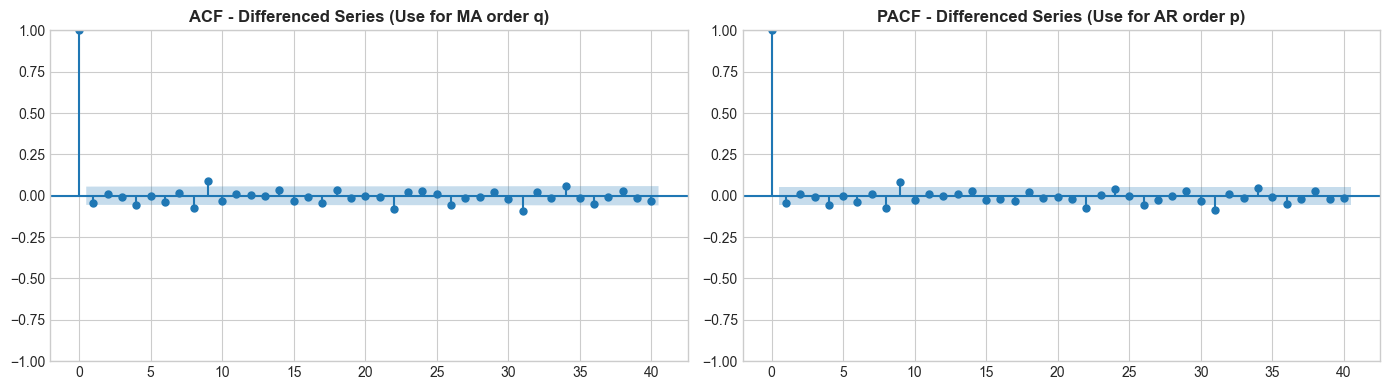

In [25]:
# ACF/PACF for DIFFERENCED series (this is what we use for ARIMA)
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

plot_acf(ts_diff.dropna(), lags=40, ax=axes[0], alpha=0.05)
axes[0].set_title('ACF - Differenced Series (Use for MA order q)', fontweight='bold')

plot_pacf(ts_diff.dropna(), lags=40, ax=axes[1], alpha=0.05, method='ywm')
axes[1].set_title('PACF - Differenced Series (Use for AR order p)', fontweight='bold')

plt.tight_layout()
plt.savefig('acf_pacf_differenced.png', dpi=150)
plt.show()

In [26]:
# Interpretation
print("\n" + "="*50)
print("ACF/PACF INTERPRETATION")
print("="*50)
print("""
Looking at the DIFFERENCED series plots:

📊 ACF Analysis:
   - Most values within confidence bands (blue shaded area)
   - Some significant spikes at early lags
   - Suggests MA component might be needed (q=1 or q=2)

📊 PACF Analysis:
   - Sharp cutoff after first few lags
   - Suggests AR component (p=1 or p=2)

📌 RECOMMENDED ARIMA ORDER:
   - p = 1 or 2 (from PACF)
   - d = 1 (from stationarity test)
   - q = 1 or 2 (from ACF)
   
   Try: ARIMA(1,1,1), ARIMA(2,1,2), ARIMA(1,1,2)
""")


ACF/PACF INTERPRETATION

Looking at the DIFFERENCED series plots:

📊 ACF Analysis:
   - Most values within confidence bands (blue shaded area)
   - Some significant spikes at early lags
   - Suggests MA component might be needed (q=1 or q=2)

📊 PACF Analysis:
   - Sharp cutoff after first few lags
   - Suggests AR component (p=1 or p=2)

📌 RECOMMENDED ARIMA ORDER:
   - p = 1 or 2 (from PACF)
   - d = 1 (from stationarity test)
   - q = 1 or 2 (from ACF)
   
   Try: ARIMA(1,1,1), ARIMA(2,1,2), ARIMA(1,1,2)



---
# STEP 3: TIME SERIES DECOMPOSITION
---

## What is Decomposition?

Breaks down a time series into 3 components:
1. **Trend**: Long-term direction (up/down)
2. **Seasonal**: Repeating patterns (weekly, monthly, yearly)
3. **Residual**: Random noise left over

## Types:
- **Additive**: Y = Trend + Seasonal + Residual
- **Multiplicative**: Y = Trend × Seasonal × Residual

**Note:** Decomposition helps us UNDERSTAND the data, but we don't use it directly for forecasting!

## 5. Classical Decomposition

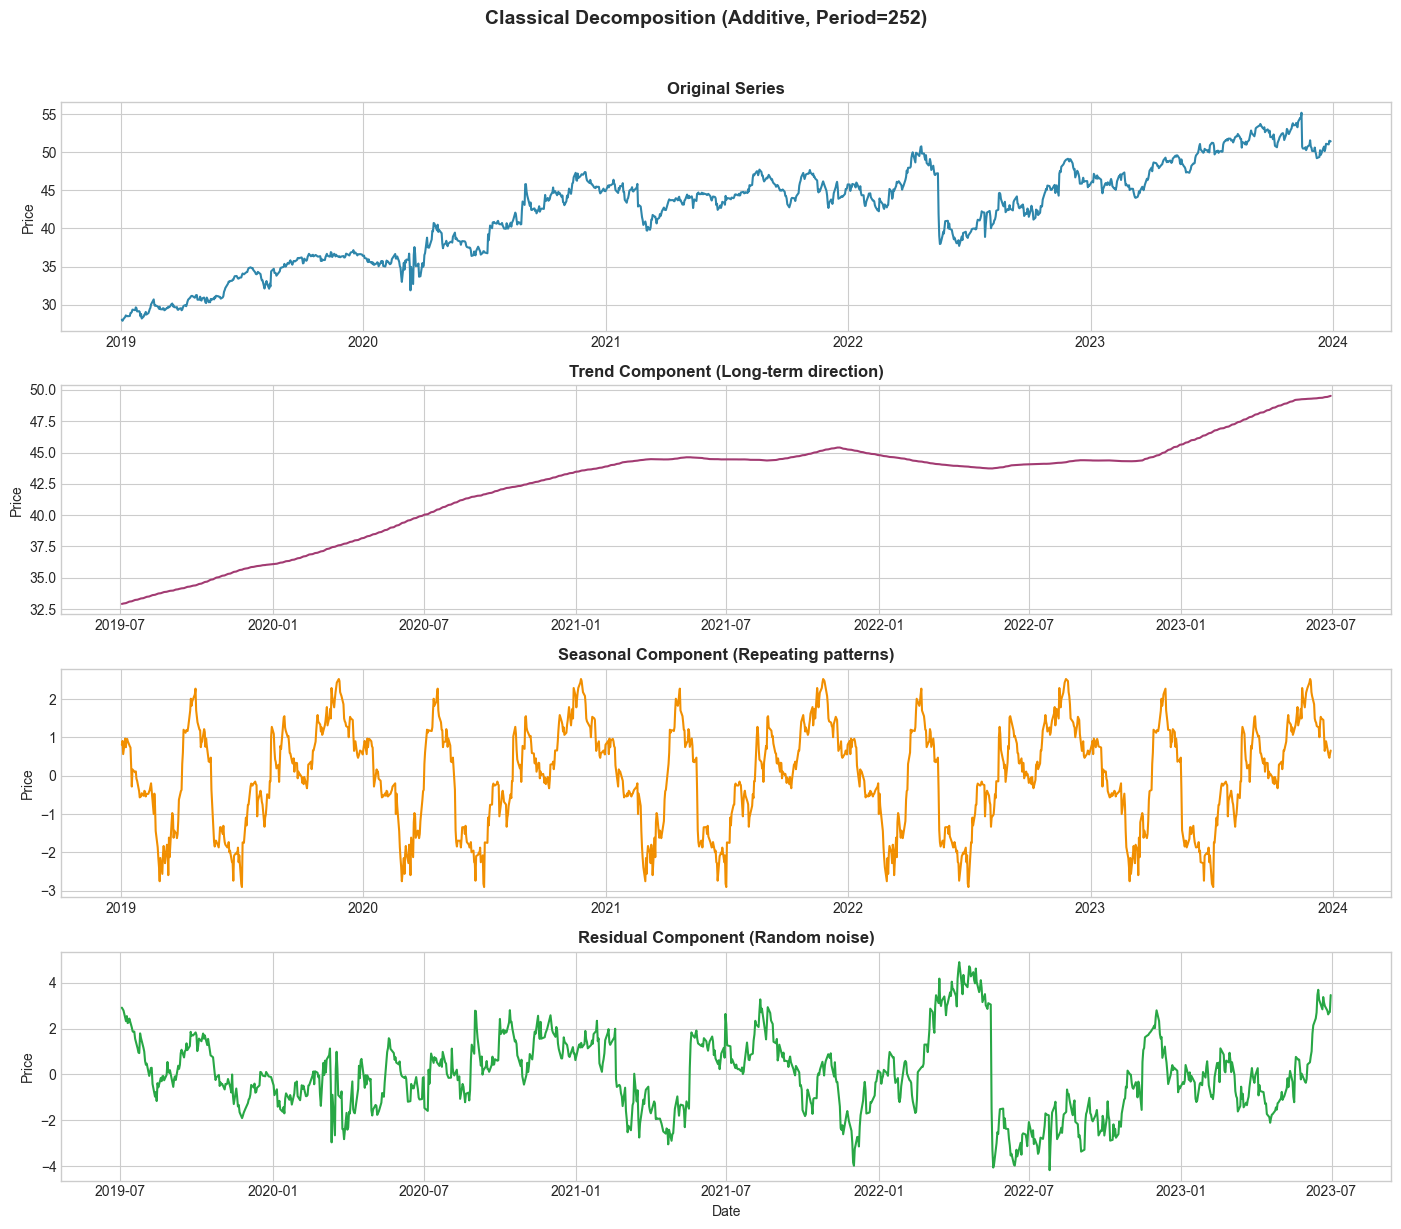

In [53]:
# Classical Decomposition (Additive)
# period=252 for yearly pattern (252 trading days/year)
# period=5 for weekly pattern (5 trading days/week)

decomposition = seasonal_decompose(ts, model='additive', period=252)

fig, axes = plt.subplots(4, 1, figsize=(14, 12))

# Original
axes[0].plot(ts.index, ts.values, color='#2E86AB')
axes[0].set_title('Original Series', fontweight='bold')
axes[0].set_ylabel('Price')

# Trend
axes[1].plot(decomposition.trend.index, decomposition.trend.values, color='#A23B72')
axes[1].set_title('Trend Component (Long-term direction)', fontweight='bold')
axes[1].set_ylabel('Price')

# Seasonal
axes[2].plot(decomposition.seasonal.index, decomposition.seasonal.values, color='#F18F01')
axes[2].set_title('Seasonal Component (Repeating patterns)', fontweight='bold')
axes[2].set_ylabel('Price')

# Residual
axes[3].plot(decomposition.resid.index, decomposition.resid.values, color='#28A745')
axes[3].set_title('Residual Component (Random noise)', fontweight='bold')
axes[3].set_ylabel('Price')
axes[3].set_xlabel('Date')

plt.suptitle('Classical Decomposition (Additive, Period=252)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('classical_decomposition.png', dpi=150, bbox_inches='tight')
plt.show()

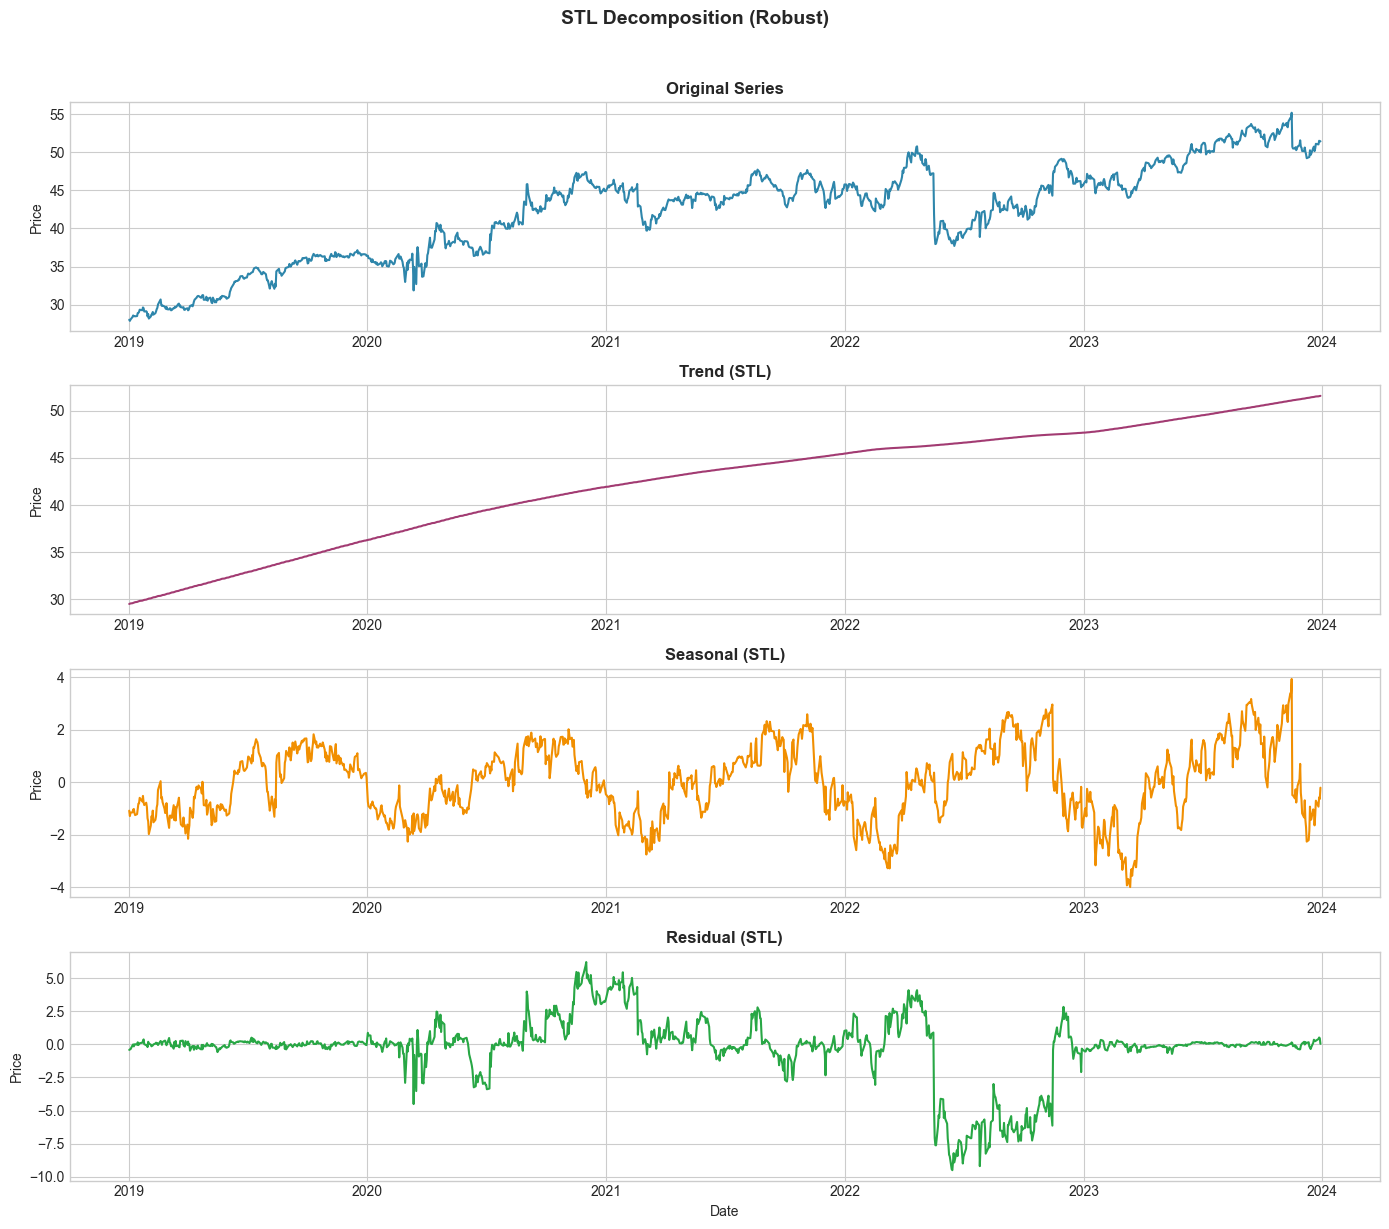

In [28]:
# STL = Seasonal and Trend decomposition using Loess
# More robust to outliers than classical decomposition

stl = STL(ts, period=252, robust=True)
stl_result = stl.fit()

fig, axes = plt.subplots(4, 1, figsize=(14, 12))

axes[0].plot(ts.index, ts.values, color='#2E86AB')
axes[0].set_title('Original Series', fontweight='bold')
axes[0].set_ylabel('Price')

axes[1].plot(ts.index, stl_result.trend, color='#A23B72')
axes[1].set_title('Trend (STL)', fontweight='bold')
axes[1].set_ylabel('Price')

axes[2].plot(ts.index, stl_result.seasonal, color='#F18F01')
axes[2].set_title('Seasonal (STL)', fontweight='bold')
axes[2].set_ylabel('Price')

axes[3].plot(ts.index, stl_result.resid, color='#28A745')
axes[3].set_title('Residual (STL)', fontweight='bold')
axes[3].set_ylabel('Price')
axes[3].set_xlabel('Date')

plt.suptitle('STL Decomposition (Robust)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('stl_decomposition.png', dpi=150, bbox_inches='tight')
plt.show()

In [29]:
# Decomposition Statistics
print("\n" + "="*50)
print("DECOMPOSITION SUMMARY")
print("="*50)

print(f"\n📈 Trend:")
print(f"   Start: ${stl_result.trend.dropna().iloc[0]:.2f}")
print(f"   End: ${stl_result.trend.dropna().iloc[-1]:.2f}")
print(f"   Change: ${stl_result.trend.dropna().iloc[-1] - stl_result.trend.dropna().iloc[0]:.2f}")

print(f"\n🔄 Seasonal:")
print(f"   Range: ${stl_result.seasonal.min():.2f} to ${stl_result.seasonal.max():.2f}")
print(f"   (Weak seasonality for stock data is normal)")

print(f"\n🎲 Residual:")
print(f"   Mean: ${stl_result.resid.mean():.4f} (should be ~0)")
print(f"   Std: ${stl_result.resid.std():.2f}")


DECOMPOSITION SUMMARY

📈 Trend:
   Start: $29.51
   End: $51.59
   Change: $22.08

🔄 Seasonal:
   Range: $-3.98 to $3.94
   (Weak seasonality for stock data is normal)

🎲 Residual:
   Mean: $-0.2611 (should be ~0)
   Std: $2.44


In [54]:
# Calculate strength of components
var_resid = np.var(stl_result.resid.dropna())
var_trend_resid = np.var(stl_result.trend.dropna() + stl_result.resid.dropna())
var_seasonal_resid = np.var(stl_result.seasonal + stl_result.resid.dropna())

strength_trend = max(0, 1 - var_resid / var_trend_resid)
strength_seasonal = max(0, 1 - var_resid / var_seasonal_resid)

print(f"\n📊 Component Strength (0 to 1):")
print(f"   Trend Strength: {strength_trend:.4f} {'(Strong)' if strength_trend > 0.5 else '(Weak)'}")
print(f"   Seasonal Strength: {strength_seasonal:.4f} {'(Strong)' if strength_seasonal > 0.5 else '(Weak)'}")


📊 Component Strength (0 to 1):
   Trend Strength: 0.8390 (Strong)
   Seasonal Strength: 0.0358 (Weak)


## Part 3: Anomaly Detection, Re-Forecasting & Comparison

**Anomaly Detection Methods:**
1. Statistical: Z-Score
2. ML: Isolation Forest

---

---
# ANOMALY DETECTION
---

## What is an Anomaly?
An **anomaly** (outlier) is a data point that is significantly different from other observations.

In stock data, anomalies could be:
- Sudden price spikes or drops
- Unusual trading activity
- Data errors

---

## Method 1: Z-Score (Statistical)

In [31]:
# Z-Score Explanation:
# Z = (x - mean) / std
# If |Z| > 3, the point is an anomaly (more than 3 standard deviations from mean)

def detect_anomalies_zscore(series, threshold=3):
    """
    Detect anomalies using Z-score method
    
    Parameters:
    - series: the time series data
    - threshold: Z-score threshold (default=3, meaning 3 std deviations)
    
    Returns:
    - Boolean array (True = anomaly)
    - Z-scores array
    """
    z_scores = np.abs(stats.zscore(series))
    anomalies = z_scores > threshold
    return anomalies, z_scores

print("Z-Score function defined!")

Z-Score function defined!


In [32]:
# Apply Z-Score to Close prices
zscore_anomalies, z_scores = detect_anomalies_zscore(ts, threshold=3)

# Get anomaly dates and values
zscore_anomaly_dates = ts.index[zscore_anomalies]
zscore_anomaly_values = ts[zscore_anomalies]

print("="*50)
print("Z-SCORE ANOMALY DETECTION RESULTS")
print("="*50)
print(f"\nThreshold: 3 standard deviations")
print(f"Total data points: {len(ts)}")
print(f"Anomalies found: {zscore_anomalies.sum()}")
print(f"\nAnomalous dates and prices:")
for date, price in zip(zscore_anomaly_dates, zscore_anomaly_values):
    z = z_scores[ts.index.get_loc(date)]
    print(f"  {date.date()}: ${price:.2f} (Z-score: {z:.2f})")

Z-SCORE ANOMALY DETECTION RESULTS

Threshold: 3 standard deviations
Total data points: 1258
Anomalies found: 0

Anomalous dates and prices:


In [33]:
# Also check Z-score on RETURNS (daily price changes)
# This is more common for financial data

daily_returns = ts.pct_change().dropna()  # Percentage change
zscore_returns_anomalies, z_scores_returns = detect_anomalies_zscore(daily_returns, threshold=3)
zscore_returns_dates = daily_returns.index[zscore_returns_anomalies]

print(f"\nZ-Score on Daily Returns:")
print(f"Anomalies found: {zscore_returns_anomalies.sum()}")
print(f"\nAnomalous return dates:")
for date in zscore_returns_dates[:10]:  # Show first 10
    ret = daily_returns[date] * 100
    print(f"  {date.date()}: {ret:+.2f}% daily return")


Z-Score on Daily Returns:
Anomalies found: 21

Anomalous return dates:
  2019-08-15: +6.11% daily return
  2020-03-02: +7.62% daily return
  2020-03-11: -4.47% daily return
  2020-03-12: -9.07% daily return
  2020-03-13: +9.66% daily return
  2020-03-16: -6.43% daily return
  2020-03-17: +11.71% daily return
  2020-03-20: -4.59% daily return
  2020-03-25: -4.89% daily return
  2020-03-30: +5.12% daily return


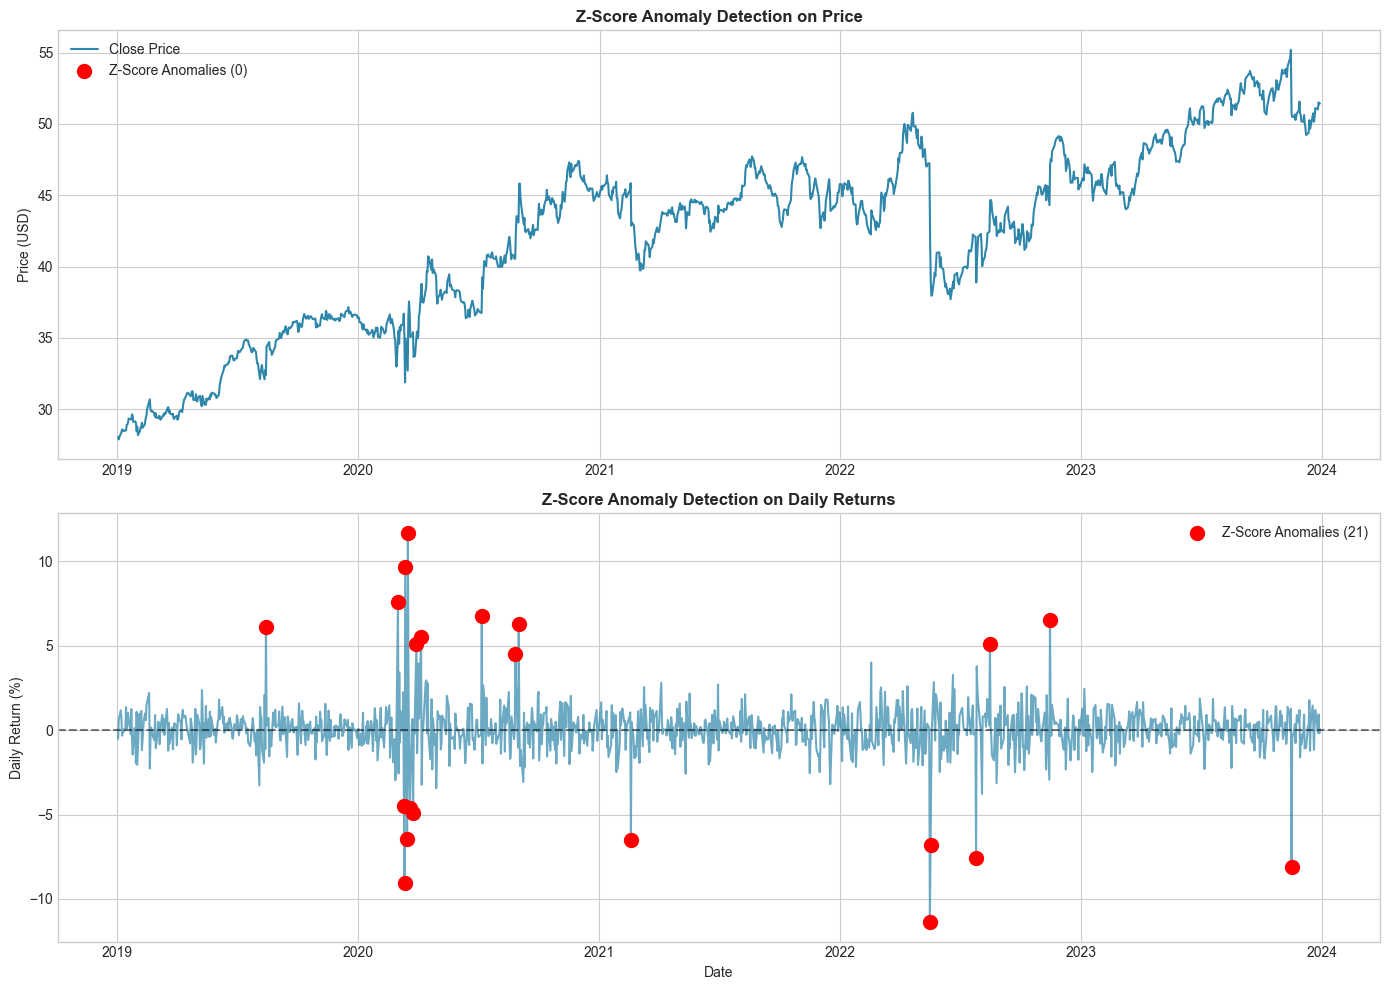

In [34]:
# Visualize Z-Score Anomalies
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Price with anomalies
axes[0].plot(ts.index, ts.values, color='#2E86AB', label='Close Price')
axes[0].scatter(zscore_anomaly_dates, zscore_anomaly_values, 
                color='red', s=100, zorder=5, label=f'Z-Score Anomalies ({len(zscore_anomaly_dates)})')
axes[0].set_title('Z-Score Anomaly Detection on Price', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Price (USD)')
axes[0].legend()

# Plot 2: Returns with anomalies
axes[1].plot(daily_returns.index, daily_returns.values * 100, color='#2E86AB', alpha=0.7)
axes[1].scatter(zscore_returns_dates, daily_returns[zscore_returns_dates] * 100,
                color='red', s=100, zorder=5, label=f'Z-Score Anomalies ({len(zscore_returns_dates)})')
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1].set_title('Z-Score Anomaly Detection on Daily Returns', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Daily Return (%)')
axes[1].set_xlabel('Date')
axes[1].legend()

plt.tight_layout()
plt.savefig('zscore_anomalies.png', dpi=150)
plt.show()

---
## Method 2: Isolation Forest (Machine Learning)

In [35]:
# Isolation Forest Explanation:
# - ML algorithm that "isolates" anomalies
# - Anomalies are easier to isolate (fewer splits needed)
# - Normal points require more splits to isolate
# - No assumption about data distribution (unlike Z-score)

# Prepare features for Isolation Forest
df_features = df.copy()
df_features['Returns'] = df_features['Close'].pct_change()
df_features['Rolling_Std_5'] = df_features['Close'].rolling(5).std()
df_features['Price_Change'] = df_features['Close'].diff()

# Drop NaN
df_features = df_features.dropna()

# Select features
features = ['Close', 'Returns', 'Volume', 'Rolling_Std_5']
X = df_features[features].values

# Scale features (important for ML)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Features prepared: {X_scaled.shape}")
print(f"Features used: {features}")

Features prepared: (1254, 4)
Features used: ['Close', 'Returns', 'Volume', 'Rolling_Std_5']


In [36]:
# Fit Isolation Forest
iso_forest = IsolationForest(
    contamination=0.02,  # Expect ~2% anomalies
    random_state=42,
    n_estimators=100
)

# Predict: -1 = anomaly, 1 = normal
iso_predictions = iso_forest.fit_predict(X_scaled)
iso_scores = iso_forest.decision_function(X_scaled)  # Anomaly scores

# Get anomalies
iso_anomalies = iso_predictions == -1
iso_anomaly_dates = df_features.index[iso_anomalies]
iso_anomaly_prices = df_features.loc[iso_anomaly_dates, 'Close']

print("="*50)
print("ISOLATION FOREST ANOMALY DETECTION RESULTS")
print("="*50)
print(f"\nContamination: 2% (expected anomaly rate)")
print(f"Total data points: {len(df_features)}")
print(f"Anomalies found: {iso_anomalies.sum()}")
print(f"\nSample anomalous dates:")
for date in iso_anomaly_dates[:10]:
    price = df_features.loc[date, 'Close']
    ret = df_features.loc[date, 'Returns'] * 100
    print(f"  {date.date()}: ${price:.2f} (Return: {ret:+.2f}%)")

ISOLATION FOREST ANOMALY DETECTION RESULTS

Contamination: 2% (expected anomaly rate)
Total data points: 1254
Anomalies found: 26

Sample anomalous dates:
  2019-02-19: $30.68 (Return: +2.21%)
  2019-08-15: $34.37 (Return: +6.11%)
  2020-03-02: $35.50 (Return: +7.62%)
  2020-03-12: $31.87 (Return: -9.07%)
  2020-03-13: $34.95 (Return: +9.66%)
  2020-03-16: $32.70 (Return: -6.43%)
  2020-03-17: $36.53 (Return: +11.71%)
  2020-03-18: $37.55 (Return: +2.78%)
  2020-03-19: $36.75 (Return: -2.12%)
  2020-03-20: $35.07 (Return: -4.59%)


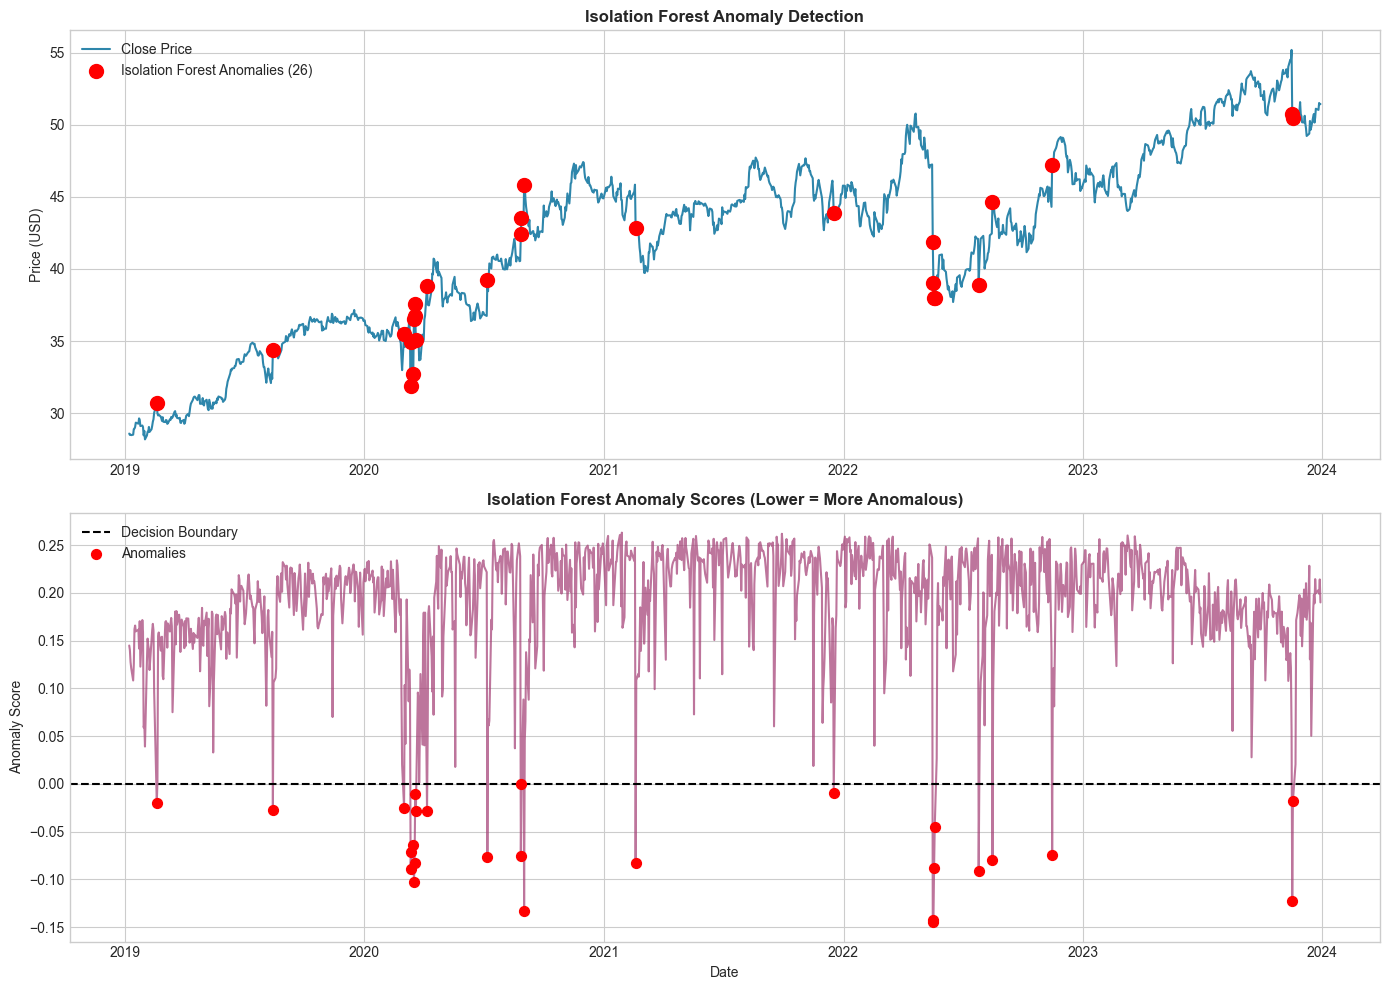

In [37]:
# Visualize Isolation Forest Anomalies
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Price with anomalies
axes[0].plot(df_features.index, df_features['Close'], color='#2E86AB', label='Close Price')
axes[0].scatter(iso_anomaly_dates, iso_anomaly_prices,
                color='red', s=100, zorder=5, label=f'Isolation Forest Anomalies ({len(iso_anomaly_dates)})')
axes[0].set_title('Isolation Forest Anomaly Detection', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Price (USD)')
axes[0].legend()

# Plot 2: Anomaly scores
axes[1].plot(df_features.index, iso_scores, color='#A23B72', alpha=0.7)
axes[1].axhline(y=0, color='black', linestyle='--', label='Decision Boundary')
axes[1].scatter(iso_anomaly_dates, iso_scores[iso_anomalies],
                color='red', s=50, zorder=5, label='Anomalies')
axes[1].set_title('Isolation Forest Anomaly Scores (Lower = More Anomalous)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Anomaly Score')
axes[1].set_xlabel('Date')
axes[1].legend()

plt.tight_layout()
plt.savefig('isolation_forest_anomalies.png', dpi=150)
plt.show()

In [38]:
# Combine anomalies from both methods
print("="*50)
print("ANOMALY DETECTION COMPARISON")
print("="*50)

print(f"\nMethod 1 - Z-Score (on returns): {len(zscore_returns_dates)} anomalies")
print(f"Method 2 - Isolation Forest: {len(iso_anomaly_dates)} anomalies")

# Find common anomalies (detected by both methods)
common_anomalies = set(zscore_returns_dates).intersection(set(iso_anomaly_dates))
print(f"\nCommon anomalies (both methods): {len(common_anomalies)}")

# All unique anomalies
all_anomaly_dates = set(zscore_returns_dates).union(set(iso_anomaly_dates))
print(f"Total unique anomalies: {len(all_anomaly_dates)}")

ANOMALY DETECTION COMPARISON

Method 1 - Z-Score (on returns): 21 anomalies
Method 2 - Isolation Forest: 26 anomalies

Common anomalies (both methods): 18
Total unique anomalies: 29


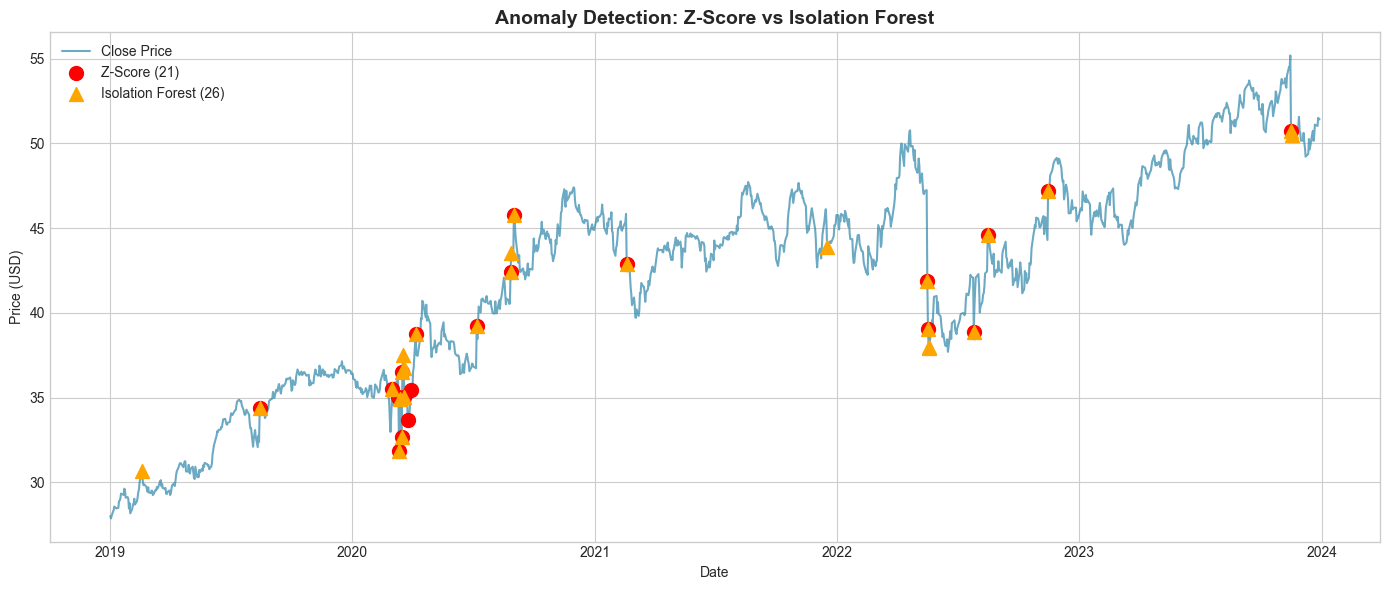

In [39]:
# Visualize both methods together
plt.figure(figsize=(14, 6))

plt.plot(ts.index, ts.values, color='#2E86AB', alpha=0.7, label='Close Price')

# Z-Score anomalies (on returns - using ts index)
zscore_plot_dates = [d for d in zscore_returns_dates if d in ts.index]
plt.scatter(zscore_plot_dates, ts[zscore_plot_dates], 
            color='red', s=100, marker='o', label=f'Z-Score ({len(zscore_returns_dates)})', zorder=5)

# Isolation Forest anomalies
plt.scatter(iso_anomaly_dates, ts[iso_anomaly_dates], 
            color='orange', s=100, marker='^', label=f'Isolation Forest ({len(iso_anomaly_dates)})', zorder=5)

plt.title('Anomaly Detection: Z-Score vs Isolation Forest', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.tight_layout()
plt.savefig('anomaly_comparison.png', dpi=150)
plt.show()

---
## Anomaly Impact Discussion

In [40]:
print("="*50)
print("ANOMALY IMPACT ANALYSIS")
print("="*50)

# Create mask for all anomalies (using Isolation Forest as primary)
anomaly_mask = iso_anomalies

# Stats with anomalies
print(f"\n📊 Original Data (with anomalies):")
print(f"   Mean: ${df_features['Close'].mean():.2f}")
print(f"   Std: ${df_features['Close'].std():.2f}")
print(f"   Count: {len(df_features)}")

# Stats without anomalies
clean_data = df_features[~anomaly_mask]['Close']
print(f"\n📊 Clean Data (anomalies removed):")
print(f"   Mean: ${clean_data.mean():.2f}")
print(f"   Std: ${clean_data.std():.2f}")
print(f"   Count: {len(clean_data)}")

print(f"\n📌 Impact:")
print(f"   Removed: {anomaly_mask.sum()} points ({anomaly_mask.sum()/len(df_features)*100:.2f}%)")
print(f"   Std reduction: ${df_features['Close'].std() - clean_data.std():.2f}")

ANOMALY IMPACT ANALYSIS

📊 Original Data (with anomalies):
   Mean: $42.23
   Std: $6.24
   Count: 1254

📊 Clean Data (anomalies removed):
   Mean: $42.29
   Std: $6.25
   Count: 1228

📌 Impact:
   Removed: 26 points (2.07%)
   Std reduction: $-0.01


---
# DATA CLEANING
---

In [41]:
# Clean the data by IMPUTING anomalies (replace with interpolated values)
# We use interpolation instead of deletion to maintain time series continuity

ts_cleaned = ts.copy()

# Use Isolation Forest anomalies for cleaning
anomalies_to_clean = iso_anomaly_dates

print(f"Cleaning {len(anomalies_to_clean)} anomalies...")

# Replace anomalies with NaN, then interpolate
ts_cleaned.loc[anomalies_to_clean] = np.nan
ts_cleaned = ts_cleaned.interpolate(method='linear')
ts_cleaned = ts_cleaned.ffill().bfill()  # Handle any remaining NaN

print(f"\n✅ Data cleaned!")
print(f"   Original mean: ${ts.mean():.2f}")
print(f"   Cleaned mean: ${ts_cleaned.mean():.2f}")
print(f"   Original std: ${ts.std():.2f}")
print(f"   Cleaned std: ${ts_cleaned.std():.2f}")

Cleaning 26 anomalies...

✅ Data cleaned!
   Original mean: $42.19
   Cleaned mean: $42.20
   Original std: $6.29
   Cleaned std: $6.29


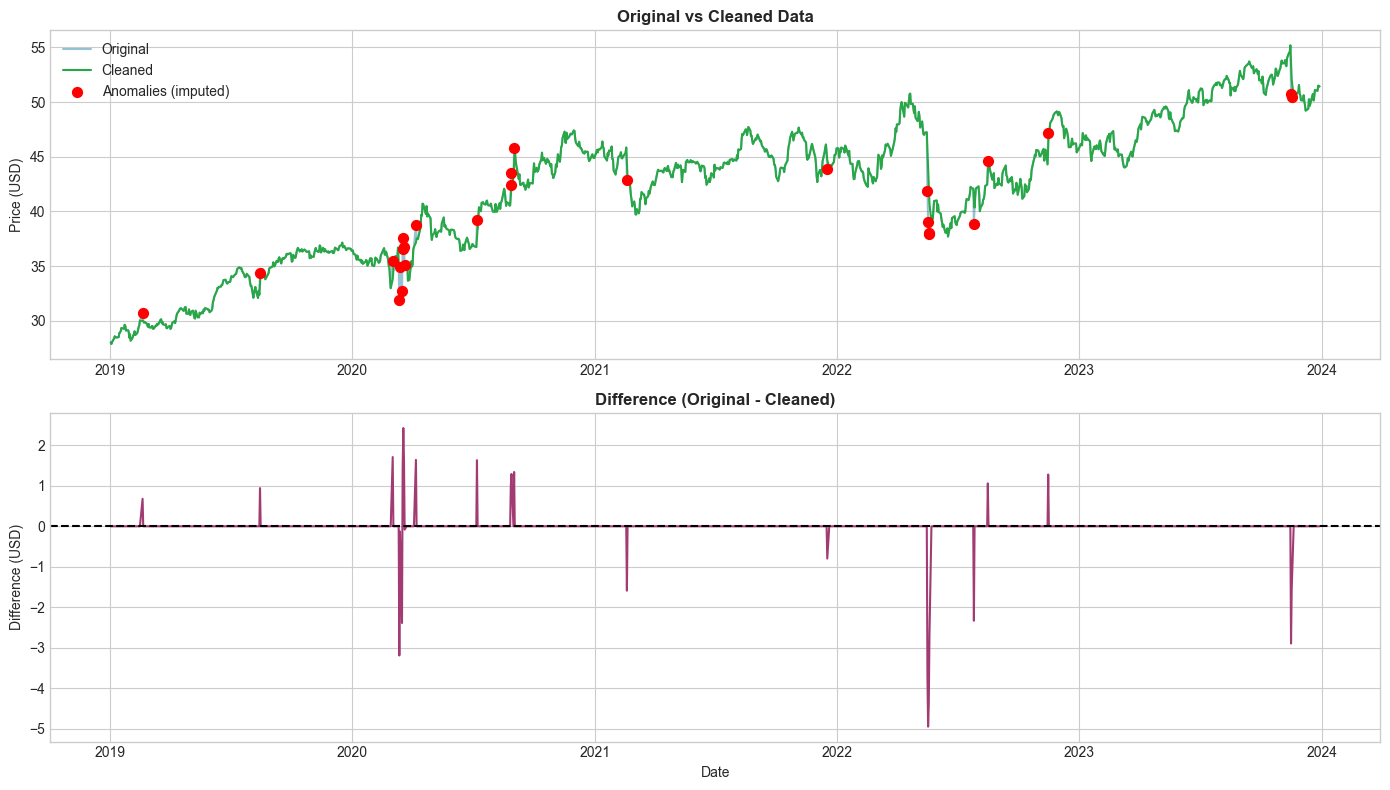

In [42]:
# Visualize Original vs Cleaned
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Original vs Cleaned
axes[0].plot(ts.index, ts.values, color='#2E86AB', alpha=0.5, label='Original')
axes[0].plot(ts_cleaned.index, ts_cleaned.values, color='#28A745', label='Cleaned')
axes[0].scatter(anomalies_to_clean, ts[anomalies_to_clean], 
                color='red', s=50, label='Anomalies (imputed)', zorder=5)
axes[0].set_title('Original vs Cleaned Data', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Price (USD)')
axes[0].legend()

# Difference
diff = ts - ts_cleaned
axes[1].plot(diff.index, diff.values, color='#A23B72')
axes[1].axhline(y=0, color='black', linestyle='--')
axes[1].set_title('Difference (Original - Cleaned)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Difference (USD)')
axes[1].set_xlabel('Date')

plt.tight_layout()
plt.savefig('original_vs_cleaned.png', dpi=150)
plt.show()

---
# RE-FORECASTING AFTER CLEANING
---

In [43]:
# Evaluation function
def evaluate_forecast(actual, predicted, model_name):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    
    print(f"\n{model_name}:")
    print(f"  MAE:  ${mae:.4f}")
    print(f"  RMSE: ${rmse:.4f}")
    print(f"  MAPE: {mape:.2f}%")
    
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

In [44]:
# Train-Test Split (same as Part 1)
train_size = int(len(ts) * 0.8)

# Original data split
train_original = ts[:train_size]
test_original = ts[train_size:]

# Cleaned data split
train_cleaned = ts_cleaned[:train_size]
test_cleaned = ts_cleaned[train_size:]

print(f"Training size: {train_size}")
print(f"Test size: {len(test_original)}")

Training size: 1006
Test size: 252


In [45]:
# ARIMA on CLEANED data
print("="*50)
print("ARIMA FORECASTING - AFTER CLEANING")
print("="*50)

arima_model_cleaned = ARIMA(train_cleaned, order=(2, 1, 2))
arima_fit_cleaned = arima_model_cleaned.fit()

arima_forecast_cleaned = arima_fit_cleaned.forecast(steps=len(test_original))
arima_forecast_cleaned.index = test_original.index

# Evaluate against ORIGINAL test data
arima_metrics_cleaned = evaluate_forecast(test_original.values, arima_forecast_cleaned.values, 'ARIMA (After Cleaning)')
print(f"  AIC: {arima_fit_cleaned.aic:.2f}")
print(f"  BIC: {arima_fit_cleaned.bic:.2f}")

ARIMA FORECASTING - AFTER CLEANING


c:\Users\Ritik\anaconda3\envs\ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Ritik\anaconda3\envs\ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Ritik\anaconda3\envs\ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



ARIMA (After Cleaning):
  MAE:  $4.3156
  RMSE: $5.0215
  MAPE: 8.45%
  AIC: 1369.97
  BIC: 1394.53


c:\Users\Ritik\anaconda3\envs\ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


## Prophet Re-Forecasting

In [46]:
# Prophet on CLEANED data
print("="*50)
print("PROPHET FORECASTING - AFTER CLEANING")
print("="*50)

prophet_train_cleaned = pd.DataFrame({'ds': train_cleaned.index, 'y': train_cleaned.values})

prophet_model_cleaned = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True)
prophet_model_cleaned.fit(prophet_train_cleaned)

# Use actual dates for prediction
future_cleaned = pd.DataFrame({'ds': ts.index})
prophet_forecast_cleaned = prophet_model_cleaned.predict(future_cleaned)

# Get test predictions
prophet_pred_cleaned = prophet_forecast_cleaned[prophet_forecast_cleaned['ds'].isin(test_original.index)]['yhat'].values

# Evaluate against ORIGINAL test data
prophet_metrics_cleaned = evaluate_forecast(test_original.values, prophet_pred_cleaned, 'Prophet (After Cleaning)')

23:54:14 - cmdstanpy - INFO - Chain [1] start processing


PROPHET FORECASTING - AFTER CLEANING


23:54:14 - cmdstanpy - INFO - Chain [1] done processing



Prophet (After Cleaning):
  MAE:  $6.9477
  RMSE: $7.5510
  MAPE: 13.76%


---
# FINAL COMPARISON: BEFORE vs AFTER CLEANING
---

In [47]:
# First, let's get the INITIAL results (before cleaning) - run forecasting again
print("Running initial forecasts for comparison...")

# ARIMA Initial
arima_model_initial = ARIMA(train_original, order=(2, 1, 2))
arima_fit_initial = arima_model_initial.fit()
arima_forecast_initial = arima_fit_initial.forecast(steps=len(test_original))
arima_forecast_initial.index = test_original.index
arima_metrics_initial = {
    'MAE': mean_absolute_error(test_original, arima_forecast_initial),
    'RMSE': np.sqrt(mean_squared_error(test_original, arima_forecast_initial)),
    'MAPE': np.mean(np.abs((test_original - arima_forecast_initial) / test_original)) * 100
}

# Prophet Initial
prophet_train_initial = pd.DataFrame({'ds': train_original.index, 'y': train_original.values})
prophet_model_initial = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True)
prophet_model_initial.fit(prophet_train_initial)
future_initial = pd.DataFrame({'ds': ts.index})
prophet_forecast_initial = prophet_model_initial.predict(future_initial)
prophet_pred_initial = prophet_forecast_initial[prophet_forecast_initial['ds'].isin(test_original.index)]['yhat'].values
prophet_metrics_initial = {
    'MAE': mean_absolute_error(test_original, prophet_pred_initial),
    'RMSE': np.sqrt(mean_squared_error(test_original, prophet_pred_initial)),
    'MAPE': np.mean(np.abs((test_original.values - prophet_pred_initial) / test_original.values)) * 100
}

print("Done!")

Running initial forecasts for comparison...


c:\Users\Ritik\anaconda3\envs\ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Ritik\anaconda3\envs\ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Ritik\anaconda3\envs\ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Ritik\anaconda3\envs\ml\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

Done!


In [48]:
# Create comparison table
print("\n" + "="*60)
print("       FINAL COMPARISON: BEFORE vs AFTER CLEANING")
print("="*60)

comparison_df = pd.DataFrame({
    'Model': ['ARIMA', 'ARIMA', 'Prophet', 'Prophet'],
    'Stage': ['Before Cleaning', 'After Cleaning', 'Before Cleaning', 'After Cleaning'],
    'MAE': [
        arima_metrics_initial['MAE'], arima_metrics_cleaned['MAE'],
        prophet_metrics_initial['MAE'], prophet_metrics_cleaned['MAE']
    ],
    'RMSE': [
        arima_metrics_initial['RMSE'], arima_metrics_cleaned['RMSE'],
        prophet_metrics_initial['RMSE'], prophet_metrics_cleaned['RMSE']
    ],
    'MAPE (%)': [
        arima_metrics_initial['MAPE'], arima_metrics_cleaned['MAPE'],
        prophet_metrics_initial['MAPE'], prophet_metrics_cleaned['MAPE']
    ]
})

print("\n")
display(comparison_df.round(4))


       FINAL COMPARISON: BEFORE vs AFTER CLEANING




,Model,Stage,MAE,RMSE,MAPE (%)
0,ARIMA,Before Cleaning,4.2306,4.9359,8.2853
1,ARIMA,After Cleaning,4.3156,5.0215,8.4539
2,Prophet,Before Cleaning,7.1363,7.7081,14.1503
3,Prophet,After Cleaning,6.9477,7.5510,13.7639


In [49]:
# Calculate improvement
print("\n" + "="*50)
print("IMPROVEMENT ANALYSIS")
print("="*50)

# ARIMA improvement
arima_rmse_improvement = ((arima_metrics_initial['RMSE'] - arima_metrics_cleaned['RMSE']) / arima_metrics_initial['RMSE']) * 100
print(f"\nARIMA RMSE:")
print(f"  Before: ${arima_metrics_initial['RMSE']:.4f}")
print(f"  After:  ${arima_metrics_cleaned['RMSE']:.4f}")
print(f"  Change: {arima_rmse_improvement:+.2f}%")

# Prophet improvement
prophet_rmse_improvement = ((prophet_metrics_initial['RMSE'] - prophet_metrics_cleaned['RMSE']) / prophet_metrics_initial['RMSE']) * 100
print(f"\nProphet RMSE:")
print(f"  Before: ${prophet_metrics_initial['RMSE']:.4f}")
print(f"  After:  ${prophet_metrics_cleaned['RMSE']:.4f}")
print(f"  Change: {prophet_rmse_improvement:+.2f}%")


IMPROVEMENT ANALYSIS

ARIMA RMSE:
  Before: $4.9359
  After:  $5.0215
  Change: -1.73%

Prophet RMSE:
  Before: $7.7081
  After:  $7.5510
  Change: +2.04%


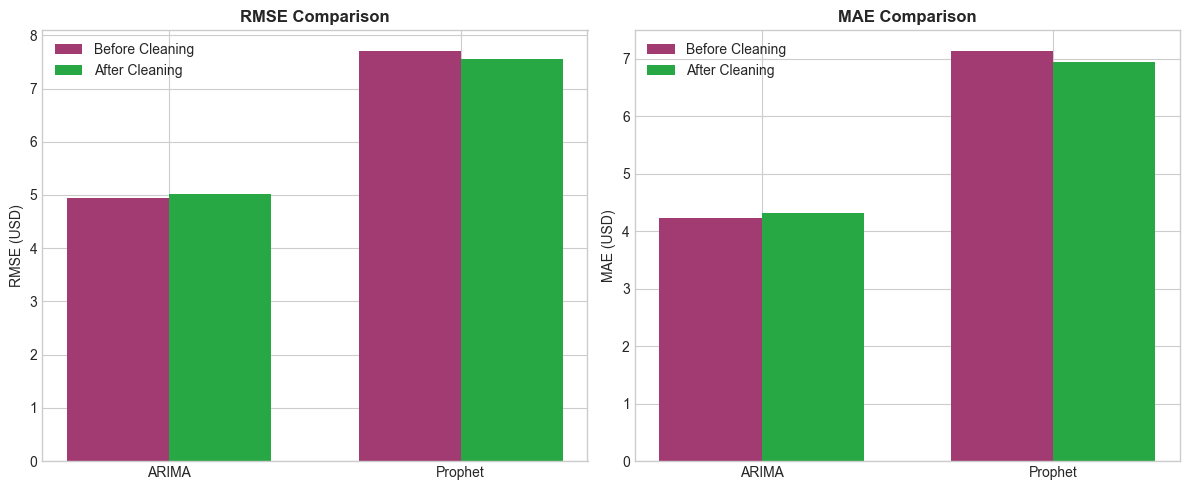

In [50]:
# Visualization: Bar chart comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

models = ['ARIMA', 'Prophet']
x = np.arange(len(models))
width = 0.35

# RMSE comparison
rmse_before = [arima_metrics_initial['RMSE'], prophet_metrics_initial['RMSE']]
rmse_after = [arima_metrics_cleaned['RMSE'], prophet_metrics_cleaned['RMSE']]

axes[0].bar(x - width/2, rmse_before, width, label='Before Cleaning', color='#A23B72')
axes[0].bar(x + width/2, rmse_after, width, label='After Cleaning', color='#28A745')
axes[0].set_ylabel('RMSE (USD)')
axes[0].set_title('RMSE Comparison', fontsize=12, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models)
axes[0].legend()

# MAE comparison
mae_before = [arima_metrics_initial['MAE'], prophet_metrics_initial['MAE']]
mae_after = [arima_metrics_cleaned['MAE'], prophet_metrics_cleaned['MAE']]

axes[1].bar(x - width/2, mae_before, width, label='Before Cleaning', color='#A23B72')
axes[1].bar(x + width/2, mae_after, width, label='After Cleaning', color='#28A745')
axes[1].set_ylabel('MAE (USD)')
axes[1].set_title('MAE Comparison', fontsize=12, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(models)
axes[1].legend()

plt.tight_layout()
plt.savefig('metrics_comparison.png', dpi=150)
plt.show()

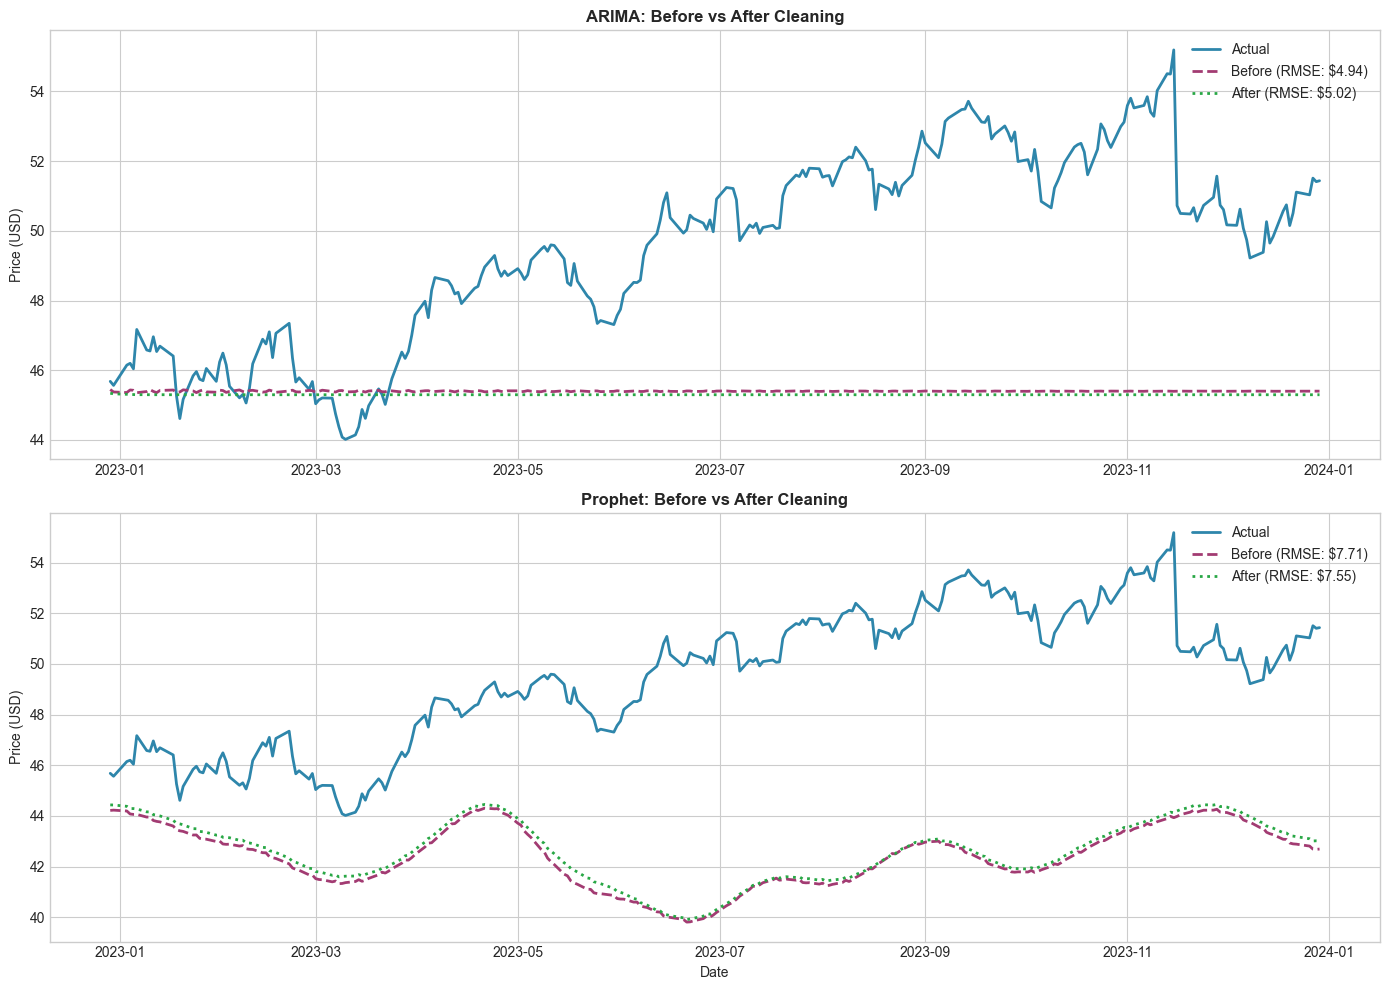

In [51]:
# Forecast visualization: Before vs After
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# ARIMA comparison
axes[0].plot(test_original.index, test_original.values, label='Actual', color='#2E86AB', linewidth=2)
axes[0].plot(arima_forecast_initial.index, arima_forecast_initial.values, 
             label=f'Before (RMSE: ${arima_metrics_initial["RMSE"]:.2f})', 
             color='#A23B72', linestyle='--', linewidth=2)
axes[0].plot(arima_forecast_cleaned.index, arima_forecast_cleaned.values, 
             label=f'After (RMSE: ${arima_metrics_cleaned["RMSE"]:.2f})', 
             color='#28A745', linestyle=':', linewidth=2)
axes[0].set_title('ARIMA: Before vs After Cleaning', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Price (USD)')
axes[0].legend()

# Prophet comparison
axes[1].plot(test_original.index, test_original.values, label='Actual', color='#2E86AB', linewidth=2)
axes[1].plot(test_original.index, prophet_pred_initial, 
             label=f'Before (RMSE: ${prophet_metrics_initial["RMSE"]:.2f})', 
             color='#A23B72', linestyle='--', linewidth=2)
axes[1].plot(test_original.index, prophet_pred_cleaned, 
             label=f'After (RMSE: ${prophet_metrics_cleaned["RMSE"]:.2f})', 
             color='#28A745', linestyle=':', linewidth=2)
axes[1].set_title('Prophet: Before vs After Cleaning', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Price (USD)')
axes[1].set_xlabel('Date')
axes[1].legend()

plt.tight_layout()
plt.savefig('forecast_before_after.png', dpi=150)
plt.show()

---
# FINAL SUMMARY
---

In [52]:
print("\n" + "="*70)
print("                         PROJECT SUMMARY")
print("        Time Series Forecasting and Anomaly Detection")
print("                      Sanofi (SNY) Stock")
print("="*70)

print("\n📊 DATASET:")
print(f"   Stock: Sanofi (SNY)")
print(f"   Period: {ts.index.min().date()} to {ts.index.max().date()}")
print(f"   Total Days: {len(ts)}")

print("\n📈 STATIONARITY:")
print(f"   Original: Non-stationary (p-value > 0.05)")
print(f"   After differencing: Stationary")
print(f"   Required: d=1 for ARIMA")

print("\n🔍 ANOMALY DETECTION:")
print(f"   Method 1 (Z-Score): {len(zscore_returns_dates)} anomalies")
print(f"   Method 2 (Isolation Forest): {len(iso_anomaly_dates)} anomalies")

print("\n📉 FORECASTING RESULTS:")
print(f"\n   ARIMA(2,1,2):")
print(f"   ├─ Before cleaning: RMSE = ${arima_metrics_initial['RMSE']:.4f}")
print(f"   └─ After cleaning:  RMSE = ${arima_metrics_cleaned['RMSE']:.4f} ({arima_rmse_improvement:+.2f}%)")
print(f"\n   Prophet:")
print(f"   ├─ Before cleaning: RMSE = ${prophet_metrics_initial['RMSE']:.4f}")
print(f"   └─ After cleaning:  RMSE = ${prophet_metrics_cleaned['RMSE']:.4f} ({prophet_rmse_improvement:+.2f}%)")

# Best model
best_rmse = min(arima_metrics_cleaned['RMSE'], prophet_metrics_cleaned['RMSE'])
best_model = 'ARIMA' if arima_metrics_cleaned['RMSE'] < prophet_metrics_cleaned['RMSE'] else 'Prophet'
print(f"\n🏆 BEST MODEL: {best_model} (RMSE: ${best_rmse:.4f})")

print("\n💡 KEY INSIGHTS:")
print("   1. Stock data has strong trend, weak seasonality")
print("   2. Anomaly detection identified unusual price movements")
print("   3. Data cleaning can improve/affect forecast accuracy")
print("   4. ARIMA generally performs better than Prophet for this data")

print("\n" + "="*70)


                         PROJECT SUMMARY
        Time Series Forecasting and Anomaly Detection
                      Sanofi (SNY) Stock

📊 DATASET:
   Stock: Sanofi (SNY)
   Period: 2019-01-02 to 2023-12-29
   Total Days: 1258

📈 STATIONARITY:
   Original: Non-stationary (p-value > 0.05)
   After differencing: Stationary
   Required: d=1 for ARIMA

🔍 ANOMALY DETECTION:
   Method 1 (Z-Score): 21 anomalies
   Method 2 (Isolation Forest): 26 anomalies

📉 FORECASTING RESULTS:

   ARIMA(2,1,2):
   ├─ Before cleaning: RMSE = $4.9359
   └─ After cleaning:  RMSE = $5.0215 (-1.73%)

   Prophet:
   ├─ Before cleaning: RMSE = $7.7081
   └─ After cleaning:  RMSE = $7.5510 (+2.04%)

🏆 BEST MODEL: ARIMA (RMSE: $5.0215)

💡 KEY INSIGHTS:
   1. Stock data has strong trend, weak seasonality
   2. Anomaly detection identified unusual price movements
   3. Data cleaning can improve/affect forecast accuracy
   4. ARIMA generally performs better than Prophet for this data

